In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('random_forest_classification').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.classification import LogisticRegression

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 01:49:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read the csv file into a DataFrame
df = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Display the content of the DataFrame
df.show()

# Get and print the number of rows in the DataFrame
num_rows = df.count()
print(f"Number of rows: {num_rows}")

+----+------+-----+-----+-----------+-------+-----+-------+------+------+------+
| age|gender|ap_hi|ap_lo|cholesterol|glucose|smoke|alcohol|active|cardio|   BMI|
+----+------+-----+-----+-----------+-------+-----+-------+------+------+------+
|55.0|     1|140.0| 90.0|          1|      0|    0|      0|     1|     1|34.928|
|52.0|     1|130.0| 70.0|          1|      0|    0|      0|     0|     1|23.508|
|48.0|     0|150.0|100.0|          0|      0|    0|      0|     1|     1| 28.71|
|48.0|     1|100.0| 80.0|          0|      0|    0|      0|     0|     0|23.011|
|60.0|     1|120.0| 80.0|          1|      1|    0|      0|     0|     0|29.385|
|62.0|     0|130.0| 90.0|          1|      1|    0|      0|     1|     1|29.984|
|48.0|     1|110.0| 70.0|          0|      0|    0|      0|     1|     0|28.441|
|54.0|     1|110.0| 80.0|          0|      0|    0|      0|     0|     0|25.283|
|52.0|     0|120.0| 80.0|          0|      0|    0|      0|     1|     0|20.047|
|54.0|     1|110.0| 70.0|   

In [3]:
# Use Spark to read in the Ecommerce Customers csv file. You can infer csv schemas. 
data = spark.read.csv("redu4.csv",inferSchema=True,header=True)

# Print the schema of the DataFrame. You can see potential features as well as the predictor.
data.printSchema()

root
 |-- age: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- glucose: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alcohol: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)



In [4]:
# 70/30
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Setting up Spark Configuration
spark = SparkSession.builder.appName('tree_methods_adv').getOrCreate()

# 1. Preparation of Data
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# 2. Label Indexing
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# 3. Vector Assembling
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
output = assembler.transform(data)

final_data = output.select("features", "indexedLabel")

# Split the data into training and test sets
train_data, test_data = final_data.randomSplit([0.7, 0.3])

# Define classifiers
dtc = DecisionTreeClassifier(labelCol='indexedLabel',featuresCol='features')
rfc = RandomForestClassifier(labelCol='indexedLabel',featuresCol='features')
gbt = GBTClassifier(labelCol='indexedLabel',featuresCol='features')

# Train the models
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
gbt_model = gbt.fit(train_data)

# Predictions
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate models
binary_evaluator = BinaryClassificationEvaluator(labelCol = 'indexedLabel')
print("DTC AUC:", binary_evaluator.evaluate(dtc_predictions))
print("RFC AUC:", binary_evaluator.evaluate(rfc_predictions))

# Note: for GBT, the rawPredictionCol should be 'prediction' by default
binary_evaluator_gbt = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction')
print("GBT AUC:", binary_evaluator_gbt.evaluate(gbt_predictions))

# Evaluate accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
print('DTC Accuracy:', acc_evaluator.evaluate(dtc_predictions))
print('RFC Accuracy:', acc_evaluator.evaluate(rfc_predictions))
print('GBT Accuracy:', acc_evaluator.evaluate(gbt_predictions))

DTC AUC: 0.6424240033556415


RFC AUC: 0.7847188736369336


23/10/08 01:50:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/08 01:50:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


GBT AUC: 0.7241464348081035


DTC Accuracy: 0.7206989766364162


RFC Accuracy: 0.7199266267619232
GBT Accuracy: 0.7249951728132844


In [13]:
# 80/20
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Setting up Spark Configuration
spark = SparkSession.builder.appName('tree_methods_adv').getOrCreate()

# 1. Preparation of Data
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# 2. Label Indexing
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# 3. Vector Assembling
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
output = assembler.transform(data)

final_data = output.select("features", "indexedLabel")

# Split the data into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2])

# Define classifiers
dtc = DecisionTreeClassifier(labelCol='indexedLabel',featuresCol='features')
rfc = RandomForestClassifier(labelCol='indexedLabel',featuresCol='features')
gbt = GBTClassifier(labelCol='indexedLabel',featuresCol='features')

# Train the models
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
gbt_model = gbt.fit(train_data)

# Predictions
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate models
binary_evaluator = BinaryClassificationEvaluator(labelCol = 'indexedLabel')
print("DTC AUC:", binary_evaluator.evaluate(dtc_predictions))
print("RFC AUC:", binary_evaluator.evaluate(rfc_predictions))

# Note: for GBT, the rawPredictionCol should be 'prediction' by default
binary_evaluator_gbt = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction')
print("GBT AUC:", binary_evaluator_gbt.evaluate(gbt_predictions))

# Evaluate accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
print('DTC Accuracy:', acc_evaluator.evaluate(dtc_predictions))
print('RFC Accuracy:', acc_evaluator.evaluate(rfc_predictions))
print('GBT Accuracy:', acc_evaluator.evaluate(gbt_predictions))

DTC AUC: 0.6206477362355212
RFC AUC: 0.7908384251124067


GBT AUC: 0.7268092400901426


DTC Accuracy: 0.7226105510999926


RFC Accuracy: 0.7231991759252446
GBT Accuracy: 0.7271723934956957


In [11]:
# RandomForest Option1:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Preparation of Data
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# 2. Label Indexing
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)

# 3. Vector Assembling
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 4. Random Forest Classifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=100)

# 5. Data Splitting
(train_data, test_data) = data.randomSplit([0.8, 0.2])

# 6. Pipeline Construction
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])

# 7. Training the Model
model = pipeline.fit(train_data)

# 8. Making Predictions
predictions = model.transform(test_data)

# 9. Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)
print(f"Area under ROC = {accuracy}")

# 10. Feature Importance
rfModel = model.stages[-1]
print("Feature Importances: " + str(rfModel.featureImportances))


Area under ROC = 0.7821135887173621
Feature Importances: (10,[0,1,2,3,4,5,6,7,8,9],[0.09995095894665941,8.524029244791521e-05,0.568230987882934,0.2228923501375823,0.08947085704986053,0.0016903256075915343,0.0005920495580094649,0.0002741095221801249,0.0010962905273323852,0.015716830475402132])


In [6]:
# RandomForest Option2:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Setting up Spark Configuration
spark = SparkSession.builder \
    .appName("Cardio Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.default.parallelism", "100") \
    .getOrCreate()

# 1. Preparation of Data
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# 2. Label Indexing
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)

# 3. Vector Assembling
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
 
# 4. Random Forest Classifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# 5. Data Splitting
(train_data, test_data) = data.randomSplit([0.8, 0.2])

# Using a sample of training data for hyperparameter tuning
sample_data = train_data.sample(withReplacement=False, fraction=0.1)

# 6. Pipeline Construction
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])

# 7. Cross Validator Setup
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                          numFolds=3)

# 8. Training the Model using Cross-Validation
cvModel = crossval.fit(sample_data)

# 9. Making Predictions on Test Data
predictions = cvModel.transform(test_data)

# 10. Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)
print(f"Area under ROC = {accuracy}")

# Getting the best Random Forest model from the cross validation
best_rf_model = cvModel.bestModel.stages[-1]
print("Best Model Feature Importances: " + str(best_rf_model.featureImportances))


best_rf_model = cvModel.bestModel.stages[-1]
print("Best Model Parameters: ")
print("Number of Trees:", best_rf_model.getNumTrees)
print("Max Depth:", best_rf_model.getOrDefault('maxDepth'))

23/10/08 01:50:41 WARN DAGScheduler: Broadcasting large task binary with size 1274.5 KiB
23/10/08 01:50:41 WARN DAGScheduler: Broadcasting large task binary with size 1908.0 KiB
23/10/08 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/10/08 01:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1736.2 KiB
23/10/08 01:50:47 WARN DAGScheduler: Broadcasting large task binary with size 1498.6 KiB
23/10/08 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/10/08 01:50:49 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 01:50:51 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/08 01:50:53 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
23/10/08 01:50:57 WARN DAGScheduler: Broadcasting large task binary with size 1251.6 KiB
23/10/08 01:50:58 WARN DAGScheduler: Broadcasting large task binary with size 1868.1 KiB
23/10/08 01:50:58 WARN DAGScheduler:

Area under ROC = 0.7858532166424722
Best Model Feature Importances: (10,[0,1,2,3,4,5,6,7,8,9],[0.13061114755711536,0.0018277157318684096,0.5503752097707231,0.20204330781200916,0.06958941335654437,0.0056492232587432335,0.0024330033129717574,0.0016565362468506906,0.002455008959409269,0.033359433993764696])
Best Model Parameters: 
Number of Trees: 100
Max Depth: 5


In [7]:
# RandomForest Option3:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("Cardiovascular Disease Prediction").getOrCreate()

# 1. Load Data
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# 2. Label Indexing
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)

# 3. Assemble Feature Vector
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 4. Initialize RandomForest Classifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# 5. Split Data for Training and Testing
(train_data, test_data) = data.randomSplit([0.8, 0.2])

# 6. Construct Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])

# 7. Setup Parameter Grid for Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# 8. CrossValidator Setup
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                          numFolds=3)

# 9. Train Model using Cross Validation
cvModel = crossval.fit(train_data)

# 10. Make Predictions on Test Data
predictions = cvModel.transform(test_data)

# 11. Evaluate Model
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)
print(f"Area under ROC = {accuracy}")

# 12. Display Best Model's Feature Importances
best_rf_model = cvModel.bestModel.stages[-1]
print("Best Model Feature Importances:", best_rf_model.featureImportances)

# 13. Display Best Model Parameters
print("Number of Trees:", best_rf_model.getNumTrees)
print("Max Depth:", best_rf_model.getOrDefault('maxDepth'))

23/10/08 01:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1680.9 KiB
23/10/08 01:51:43 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/08 01:51:46 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/10/08 01:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1041.7 KiB
23/10/08 01:51:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/08 01:52:07 WARN DAGScheduler: Broadcasting large task binary with size 1741.1 KiB
23/10/08 01:52:11 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/08 01:52:16 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
23/10/08 01:52:19 WARN DAGScheduler: Broadcasting large task binary with size 1389.0 KiB
23/10/08 01:52:21 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
23/10/08 01:52:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/08 01:52:26 WARN DAGScheduler: Broad

Area under ROC = 0.791630783902399
Best Model Feature Importances: (10,[0,1,2,3,4,5,6,7,8,9],[0.14826796407475648,0.006194272790555193,0.5033462682881616,0.1815941023986837,0.07555569899139145,0.008615856083781955,0.006120872042470398,0.005260515722247223,0.009357592579698419,0.055686857028253496])
Number of Trees: 100
Max Depth: 10


In [8]:
# Decision Tree Option1 (70/30):
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark session
spark = SparkSession.builder.appName("CardioAnalysis").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Prepare the data
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Convert 'cardio' column to an index
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# Split the data
train_data, test_data = data.randomSplit([0.7, 0.3])

# Decision Tree setup
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features")

# Grid of parameters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [32, 64, 128]) \
    .build()

# Cross validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions
predictions = cvModel.transform(test_data)

# Evaluate the best model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Best Model Accuracy: ", accuracy)

# Get and print the optimal parameters
best_dt_model = cvModel.bestModel
print("Best Max Depth: ", best_dt_model.getMaxDepth())
print("Best Max Bins: ", best_dt_model.getMaxBins())


Best Model Accuracy:  0.714828714395689
Best Max Depth:  5
Best Max Bins:  32


In [16]:
# Decision Tree Option1 (80/20):
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark session
spark = SparkSession.builder.appName("CardioAnalysis").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Prepare the data
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Convert 'cardio' column to an index
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# Split the data
train_data, test_data = data.randomSplit([0.8, 0.2])

# Decision Tree setup
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features")

# Grid of parameters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [32, 64, 128]) \
    .build()

# Cross validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions
predictions = cvModel.transform(test_data)

# Evaluate the best model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Best Model Accuracy: ", accuracy)

# Get and print the optimal parameters
best_dt_model = cvModel.bestModel
print("Best Max Depth: ", best_dt_model.getMaxDepth())
print("Best Max Bins: ", best_dt_model.getMaxBins())


Best Model Accuracy:  0.7188630117170548
Best Max Depth:  5
Best Max Bins:  32


In [9]:
# Decision Tree Option2 (70/30):
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark session
spark = SparkSession.builder.appName("CardioAnalysis").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Prepare the data
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")
data = assembler.transform(data)

# Scale the features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

# Convert 'cardio' column to an index
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# Split the data
train_data, test_data = data.randomSplit([0.7, 0.3])

# Decision Tree setup
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features")

# Expanded Grid of parameters
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [4, 5, 6, 10, 15, 20]) \
    .addGrid(dt.maxBins, [16, 32, 64, 128, 256]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

# Cross validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions
predictions = cvModel.transform(test_data)

# Evaluate the best model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Best Model Accuracy: ", accuracy)

# Get and print the optimal parameters
best_dt_model = cvModel.bestModel
print("Best Max Depth: ", best_dt_model.getMaxDepth())
print("Best Max Bins: ", best_dt_model.getMaxBins())
print("Best Impurity: ", best_dt_model.getImpurity())


23/10/08 01:56:38 WARN DAGScheduler: Broadcasting large task binary with size 1165.0 KiB
23/10/08 01:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1373.0 KiB
23/10/08 01:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1574.7 KiB
23/10/08 01:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1751.5 KiB
23/10/08 01:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1069.5 KiB
23/10/08 01:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1264.9 KiB
23/10/08 01:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1456.4 KiB
23/10/08 01:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1639.7 KiB
23/10/08 01:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1076.0 KiB
23/10/08 01:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1275.8 KiB
23/10/08 01:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1483.4 KiB
23/10/08 01:56:45 WAR

23/10/08 01:59:47 WARN DAGScheduler: Broadcasting large task binary with size 1343.5 KiB
23/10/08 01:59:50 WARN DAGScheduler: Broadcasting large task binary with size 1089.8 KiB
23/10/08 01:59:50 WARN DAGScheduler: Broadcasting large task binary with size 1256.5 KiB
23/10/08 01:59:50 WARN DAGScheduler: Broadcasting large task binary with size 1423.7 KiB
23/10/08 01:59:54 WARN DAGScheduler: Broadcasting large task binary with size 1076.7 KiB
23/10/08 01:59:54 WARN DAGScheduler: Broadcasting large task binary with size 1220.5 KiB


Best Model Accuracy:  0.7212621359223301
Best Max Depth:  6
Best Max Bins:  16
Best Impurity:  gini


In [14]:
# Decision Tree Option2 (80/20):
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark session
spark = SparkSession.builder.appName("CardioAnalysis").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Prepare the data
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")
data = assembler.transform(data)

# Scale the features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

# Convert 'cardio' column to an index
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# Split the data
train_data, test_data = data.randomSplit([0.8, 0.2])

# Decision Tree setup
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features")

# Expanded Grid of parameters
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [4, 5, 6, 10, 15, 20]) \
    .addGrid(dt.maxBins, [16, 32, 64, 128, 256]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

# Cross validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions
predictions = cvModel.transform(test_data)

# Evaluate the best model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Best Model Accuracy: ", accuracy)

# Get and print the optimal parameters
best_dt_model = cvModel.bestModel
print("Best Max Depth: ", best_dt_model.getMaxDepth())
print("Best Max Bins: ", best_dt_model.getMaxBins())
print("Best Impurity: ", best_dt_model.getImpurity())


23/10/08 02:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1064.9 KiB
23/10/08 02:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1301.8 KiB
23/10/08 02:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1549.4 KiB
23/10/08 02:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1790.4 KiB
23/10/08 02:50:23 WARN DAGScheduler: Broadcasting large task binary with size 2008.4 KiB
23/10/08 02:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1046.3 KiB
23/10/08 02:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1182.2 KiB
23/10/08 02:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1415.9 KiB
23/10/08 02:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1656.2 KiB
23/10/08 02:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1886.6 KiB
23/10/08 02:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1009.1 KiB
23/10/08 02:50:29 WAR

23/10/08 02:53:25 WARN DAGScheduler: Broadcasting large task binary with size 1826.6 KiB
23/10/08 02:53:25 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB
23/10/08 02:53:27 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB
23/10/08 02:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1241.3 KiB
23/10/08 02:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1451.4 KiB
23/10/08 02:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1665.0 KiB
23/10/08 02:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1109.5 KiB
23/10/08 02:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1314.6 KiB
23/10/08 02:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1525.8 KiB
23/10/08 02:53:32 WARN DAGScheduler: Broadcasting large task binary with size 1734.7 KiB
23/10/08 02:53:32 WARN DAGScheduler: Broadcasting large task binary with size 1043.3 KiB
23/10/08 02:53:34 WAR

Best Model Accuracy:  0.7237935559119405
Best Max Depth:  6
Best Max Bins:  32
Best Impurity:  gini


In [10]:
# Logistic Regression (70/30):
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark Session
spark = SparkSession.builder.appName("LogisticRegressionTuning").getOrCreate()

# Load and prepare the data
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Convert features using VectorAssembler
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Convert 'cardio' column to a numerical index
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# Split data for training and testing
train_data, test_data = data.randomSplit([0.7, 0.3])

# Logistic Regression setup
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

# We will use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel")

# Cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 5-fold CrossValidation

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

# Making predictions on test data
predictions = cvModel.transform(test_data)

# Model Evaluation
accuracy = evaluator.evaluate(predictions)
print(f"Best Model Accuracy = {accuracy}")
print("Best Model Parameters:")
best_params = cvModel.bestModel.extractParamMap()
for p in best_params:
    print(f"{p.name}: {best_params[p]}")

Best Model Accuracy = 0.7879547304361257
Best Model Parameters:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: indexedLabel
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.5
tol: 1e-06


In [12]:
# Logistic Regression (80/20):
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark Session
spark = SparkSession.builder.appName("LogisticRegressionTuning").getOrCreate()

# Load and prepare the data
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Convert features using VectorAssembler
feature_columns = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'BMI']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Convert 'cardio' column to a numerical index
labelIndexer = StringIndexer(inputCol="cardio", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# Split data for training and testing
train_data, test_data = data.randomSplit([0.8, 0.2])

# Logistic Regression setup
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

# We will use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel")

# Cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 5-fold CrossValidation

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

# Making predictions on test data
predictions = cvModel.transform(test_data)

# Model Evaluation
accuracy = evaluator.evaluate(predictions)
print(f"Best Model Accuracy = {accuracy}")
print("Best Model Parameters:")
best_params = cvModel.bestModel.extractParamMap()
for p in best_params:
    print(f"{p.name}: {best_params[p]}")

Best Model Accuracy = 0.7885613927821966
Best Model Parameters:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: indexedLabel
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.5
tol: 1e-06


Silhouette with squared euclidean distance = 0.2726335237218056


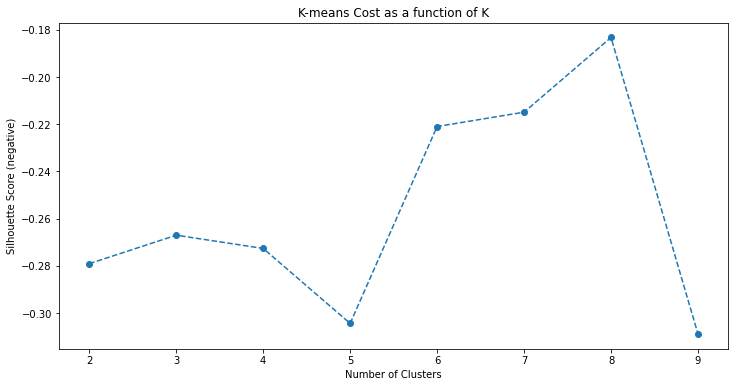

In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Create Spark session
spark = SparkSession.builder.appName("kmeans_clustering").getOrCreate()

# Load data into Spark DataFrame
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Assemble features with VectorAssembler
features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'gender', 'BMI', 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
data = assembler.transform(data)

# Scale the features
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# K-means clustering
n_clusters = 4
kmeans = KMeans(featuresCol='scaled_features', k=n_clusters, predictionCol="prediction")
model = kmeans.fit(data)
predictions = model.transform(data)

# Evaluate clustering
evaluator = ClusteringEvaluator(featuresCol="scaled_features")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Determine the optimal number of clusters using the Elbow Method
cost = []
for k in range(2, 10):  # example range
    kmeans = KMeans(featuresCol='scaled_features', k=k, predictionCol="prediction")
    model = kmeans.fit(data)
    predictions_temp = model.transform(data)
    evaluator = ClusteringEvaluator(featuresCol="scaled_features")
    silhouette = evaluator.evaluate(predictions_temp)
    cost.append(-silhouette)

# Plotting the cost values to determine the elbow
plt.figure(figsize=(12,6))
plt.plot(range(2, 10), cost, marker='o', linestyle='--')
plt.title('K-means Cost as a function of K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score (negative)')
plt.show()


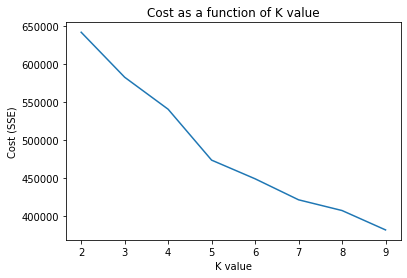

In [28]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Check if "data" already has the "features_vec" column; if not, assemble the features
if "features_vec" not in data.columns:
    assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
    data = assembler.transform(data)

# If "data" doesn't have the "scaled_features" column, then perform feature scaling
if "scaled_features" not in data.columns:
    scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
    scaler_model = scaler.fit(data)
    data = scaler_model.transform(data)

# Track the cost for each K value
costs = []
K_values = list(range(2, 10))  # You can adjust the range as needed
for k in K_values:
    kmeans = KMeans().setK(k).setFeaturesCol("scaled_features").setPredictionCol("prediction")
    model = kmeans.fit(data)
    cost = model.summary.trainingCost
    costs.append(cost)

# Plot the cost
plt.plot(K_values, costs)
plt.xlabel('K value')
plt.ylabel('Cost (SSE)')
plt.title('Cost as a function of K value')
plt.show()
